pmgus_vbeta.ipynb

In [9]:
import pandas as pd
import numpy as np
pd.set_option('display.colheader_justify', 'left')  # Left-align column headers
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
from datetime import datetime, timedelta
#
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pytz
from tqdm import tqdm  # Visualize loop progress
from sklearn.linear_model import LinearRegression
from tenacity import retry, stop_after_attempt, wait_fixed
import openpyxl
import os
import requests
import yfinance as yf

In [10]:
# tradingview lightweight-charts
from lightweight_charts import Chart
import asyncio
import nest_asyncio
# Apply nest_asyncio AT START to allow nested event loops (required for Jupyter)
nest_asyncio.apply()
#
from dotenv import load_dotenv

In [3]:
# load env vars
load_dotenv()

True

In [11]:
# base file path and file path setup
base_dir_path = '/Users/sudz4/Desktop/SPS_local/sps/x_pre_market_gap_up_screener/pmgus_inputs/' 
tv_prefix = 'tv_screen_gap-up_'
file_type_csv = '.csv'
#####---------------------#####
# screen_date = '2024-12-17' # worse day
# screen_date = '2024-12-18' # better day
# screen_date = '2024-12-20' # not worse day
#25
# screen_date = '2025-01-07' # next
# screen_date = '2025-01-10'
# screen_date = '2025-01-13'
# screen_date = '2025-01-14'
screen_date = '2025-01-16'

#####---------------------#####
tv_filename = base_dir_path + tv_prefix + screen_date + file_type_csv

# READ
trading_view_df = pd.read_csv(tv_filename)

# # PRINT
# print(tv_filename)
print(len(trading_view_df))
# # print first 5 ticker Symbols only
# print(trading_view_df['Symbol'].head(5))

1547


| initial screener |
|-|
setup market cap category groups, criteria configurations, and conditional filtering.

data import (manual) TradingView

In [12]:
# CREATE CATEGORIES FOR MARKET CAP
def categorize_market_cap(df):
    # categorize stocks groups by market cap
    df['Market capitalization'] = pd.to_numeric(df['Market capitalization'], errors='coerce')
    conditions = [
        (df['Market capitalization'] >= 200_000_000_000),  # Titans
        (df['Market capitalization'] >= 10_000_000_000) & (df['Market capitalization'] < 200_000_000_000),  # Large caps
        (df['Market capitalization'] >= 2_000_000_000) & (df['Market capitalization'] < 10_000_000_000),  # Mid caps
        (df['Market capitalization'] >= 300_000_000) & (df['Market capitalization'] < 2_000_000_000),  # Small caps
        (df['Market capitalization'] > 50_000_000) & (df['Market capitalization'] < 300_000_000),  # Micro caps
        (df['Market capitalization'] <= 50_000_000)  # Shrimp
    ]
    # marekt cap categories list
    categories = ['Titans', 'Large caps', 'Mid caps', 'Small caps', 'Micro caps', 'Shrimp']
    df['marketCapType'] = np.select(conditions, categories, default='Undefined')
    return df
# execute categorization
category_setup_df = categorize_market_cap(trading_view_df).copy()
# drop Undefined marketCapType
category_setup_df = category_setup_df[category_setup_df['marketCapType'] != 'Undefined']

# convert necessary columns to numeric
def convert_columns_to_numeric(df, columns):
    """Convert specified columns to numeric types."""
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

# list of columns to convert
numeric_columns = [
    'Market capitalization', 'Float shares outstanding', 'Relative Volume 1 day',
    'Relative Volume at Time', 'Pre-market Change %', 'Pre-market Gap %',
    'Price', 'Volume Weighted Average Price 1 day', 'Volatility 1 day',
    'Volatility 1 week', 'Volatility 1 month', 'Pre-market Volume'
]

# apply conversion
category_setup_df = convert_columns_to_numeric(category_setup_df, numeric_columns)

# CRITERIA CONFIGURATION FOR EACH MARKET CAP CATEGORY
criteria_config = {
    "Titans": {
        "pre_market_change_pct_threshold": 0.002,  # 0.2% for Titans
        "float_shares_outstanding_threshold": 1_000_000_000,  # 1 billion shares
        "relative_volume_threshold": 1.2,
        "relative_volume_at_time_threshold": 0.03,
        "pre_market_gap_percentage_threshold": 0.001,  # 0.1%
        "pre_market_vwap_drawdown_threshold": 0.003,  # 0.3% drawdown from VWAP
        "pre_market_volume_threshold": 50_000  # Minimum pre-market volume
    },
    "Large caps": {
        "pre_market_change_pct_threshold": 0.005,  # 0.5% for Large caps
        "float_shares_outstanding_threshold": 200000000,  # 200 million shares
        "relative_volume_threshold": 1.3,  # More inclusive
        "relative_volume_at_time_threshold": 0.04,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.005,  # 0.5%
        "pre_market_vwap_drawdown_threshold": 0.004,  # 0.4% drawdown from VWAP
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    },
    "Midlers": { 
        "pre_market_change_pct_threshold": 0.02,  # 2% for Midlers 
        "float_shares_outstanding_threshold": 50000000,  # 50 million shares
        "relative_volume_threshold": 1.3,
        "relative_volume_at_time_threshold": 0.05,
        "pre_market_gap_percentage_threshold": 0.02,
        "pre_market_vwap_drawdown_threshold": 0.005,  # 0.5% drawdown from VWAP
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    },
    "Small caps": {
        "pre_market_change_pct_threshold": 0.03,  # 3% for Small caps
        "float_shares_outstanding_threshold": 20000000,  # 20 million shares
        "relative_volume_threshold": 1.2,
        "relative_volume_at_time_threshold": 0.05,
        "pre_market_gap_percentage_threshold": 0.03,
        "pre_market_vwap_drawdown_threshold": 0.006,  # 0.6% drawdown from VWAP
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    },
    "Micro caps": {
        "pre_market_change_pct_threshold": 0.04,  # 4% for Micro caps
        "float_shares_outstanding_threshold": 5000000,  # 5 million shares
        "relative_volume_threshold": 1.1,
        "relative_volume_at_time_threshold": 0.05,
        "pre_market_gap_percentage_threshold": 0.04,
        "pre_market_vwap_drawdown_threshold": 0.007,  # 0.7% drawdown from VWAP
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    },
    "Shrimp": {
        "pre_market_change_pct_threshold": 0.05,  # 5% for Shrimp
        "float_shares_outstanding_threshold": 1000000,  # 1 million shares
        "relative_volume_threshold": 1.0,
        "relative_volume_at_time_threshold": 0.05,
        "pre_market_gap_percentage_threshold": 0.05,
        "pre_market_vwap_drawdown_threshold": 0.008, # 0.8% drawdown from VWAP
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    }
}

# FILTER STOCKS BASED ON CONFIGURATION CRITERIA - STAGING
def filter_stocks(df, config):
    # stock filtering conditions >=< based on criteria
    conditions = (
        (df['Pre-market Change %'] >= config.get('pre_market_change_pct_threshold', 0)) &
        (df['Float shares outstanding'] <= config.get('float_shares_outstanding_threshold', float('inf'))) &
        (df['Relative Volume 1 day'] >= config.get('relative_volume_threshold', 0)) &
        (df['Relative Volume at Time'] >= config.get('relative_volume_at_time_threshold', 0)) &
        (df['Pre-market Gap %'] >= config.get('pre_market_gap_percentage_threshold', 0)) &
        (df['Price'] >= df['Volume Weighted Average Price 1 day'] * (1 - config.get('pre_market_vwap_drawdown_threshold', 0))) &
        (df['Volatility 1 day'] >= df['Volatility 1 week']) &
        (df['Volatility 1 day'] >= df['Volatility 1 month']) &
        (df['Pre-market Volume'] >= config.get('pre_market_volume_threshold', 0))
    )
    return df[conditions]

# SCREEN STOCKS BY CATEGORY
def screen_stocks_by_category(df, category):
    """Filter stocks in a category using predefined criteria."""
    config = criteria_config.get(category, {})
    filtered_df = filter_stocks(df, config)
    return filtered_df

# EXECUTE KEY SCREENING FUNCTION AND CREATE DATAFRAME
smash_df = pd.DataFrame()
categories = category_setup_df['marketCapType'].unique()

for category in categories:
    category_df = category_setup_df[category_setup_df['marketCapType'] == category]
    gap_up_stage_df = screen_stocks_by_category(category_df, category)
    smash_df = pd.concat([smash_df, gap_up_stage_df], ignore_index=True)

# rendered column list and ordering
cols_list = [
    'Symbol', 
    'Description', 
    'marketCapType', 
    'Pre-market Change %', 
    'Pre-market Gap %', 
    'Market capitalization',
    'Price', 
    'Pre-market Open', 
    'Industry', 
    'Index', 
    'Sector', 
    'Exchange',
    'Recent earnings date', 
    'Upcoming earnings date', 
    'Float shares outstanding', 
    'Average Volume 10 days',
    'Average Volume 30 days', 
    'Average Volume 90 days',
    'Relative Volume 1 day', 
    'Relative Volume 5 minutes', 
    'Relative Volume 30 minutes', 
    'Relative Volume at Time', 
    'Analyst Rating',
    'Technical Rating 5 minutes'
]

# filter columns to only include those present in the DataFrame
existing_cols = [col for col in cols_list if col in smash_df.columns]
smash_df = smash_df[existing_cols]

# sort and reset index
smash_df = smash_df.sort_values(
    by=['Pre-market Change %', 'Price'],
    ascending=[False, False]).reset_index(drop=True)

print(f"{smash_df.shape[0]} stocks found.")
display(smash_df.head(2))
# # ALL SMASH
# display(smash_df)

50 stocks found.


,Symbol,Description,marketCapType,Pre-market Change %,Pre-market Gap %,Market capitalization,Price,Pre-market Open,Industry,Index,Sector,Exchange,Recent earnings date,Upcoming earnings date,Float shares outstanding,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Relative Volume 1 day,Relative Volume 5 minutes,Relative Volume 30 minutes,Relative Volume at Time,Analyst Rating,Technical Rating 5 minutes
0,DNLI,Denali Therapeutics Inc.,Mid caps,9.491163,10.697674,3.094315e+09,21.50,23.80,Biotechnology,"NASDAQ Composite, Russell 2000, Nasdaq US Small Cap Growth, Russell 3000, NASDAQ Biotechnology, Mini-Russell 2000",Health technology,NASDAQ,2024-11-06,2025-03-03,1.245913e+08,1118472.1,963079.133333,913339.622222,1.635402,4.416527,6.435811,1.806468,Strong buy,Neutral
1,CAMT,Camtek Ltd.,Mid caps,4.525032,3.027386,4.240828e+09,93.48,96.31,Electronic components,"NASDAQ Composite, NASDAQ Computer",Electronic technology,NASDAQ,2024-11-12,2025-02-13,2.787667e+07,404980.8,485887.066667,543766.911111,1.355166,4.277527,3.108942,1.416076,Strong buy,Buy


In [13]:
# group and count by sector to new df called sector_count_df
sector_count_df = smash_df.groupby('Sector').size().reset_index(name='Count').sort_values(by='Count', ascending=False)
# print the date and time of the screen
print(f"Screening date: {screen_date}")
print(f"Total stocks returned: {len(smash_df)}")
display(sector_count_df)

Screening date: 2025-01-16
Total stocks returned: 50


,Sector,Count
11,Technology services,14
5,Finance,10
3,Electronic technology,6
10,Producer manufacturing,6
7,Health technology,4
0,Commercial services,2
9,Non-energy minerals,2
1,Communications,1
2,Consumer services,1
4,Energy minerals,1


# START incision_df DEVELOPEMENT

In [38]:
# go through each indicator and develop "Matthew's Cross". 
# can also do Matthew's Cross jr and small, XL etc. versions.
# this is Matthew's Trading view, our tradingview custom strategy

# END incision_df DEVELOPEMENT

In [39]:
# # DEVELOPEMENT
# print(len(cols_list))

| quick and dirty filter |
|-|

might want to get rid of this later 
3 way filter with MatthView and other technical strategies
Matthview is it's own strategy, but you need to look for lag

In [14]:
# quick and dirty filter for high-probability morning momentum trades (Re: Pre-market Gap Up)
def quick_dirty_filter(df):
    return df[
        # strong pre-market movement but not overextended
        (
            (df['Pre-market Change %'] > 3.0) |
            ((df['Pre-market Change %'] > 1.5) & (df['Relative Volume 5 minutes'] > 5.0))
        ) &
        # volume validation
        (df['Relative Volume 5 minutes'] > 2.0) &
        # industry/sector grouping
        (df.groupby('Industry')['Pre-market Change %'].transform('count') > 1)
            ].sort_values('Pre-market Change %', ascending=False)

In [15]:
# EXECUTE quick and dirty filter && CREATE a df and list
quick_dirty_df = quick_dirty_filter(smash_df)
quick_dirty_list = quick_dirty_df['Symbol'].to_list()

# PRINT
print(f'{len(quick_dirty_df)} stocks returned from the quick and dirty filter.')
# print(smash_qd_df.columns)
print(quick_dirty_list)
# display(smash_qd_df)
display(quick_dirty_df.head(5))
# # ALL QUICK AND DIRTY
# display(quick_dirty_df)

8 stocks returned from the quick and dirty filter.
['DNLI', 'OS', 'SEI', 'BILL', 'IMVT', 'SMTC', 'ACLS', 'CADE/PA']


,Symbol,Description,marketCapType,Pre-market Change %,Pre-market Gap %,Market capitalization,Price,Pre-market Open,Industry,Index,Sector,Exchange,Recent earnings date,Upcoming earnings date,Float shares outstanding,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Relative Volume 1 day,Relative Volume 5 minutes,Relative Volume 30 minutes,Relative Volume at Time,Analyst Rating,Technical Rating 5 minutes
0,DNLI,Denali Therapeutics Inc.,Mid caps,9.491163,10.697674,3.094315e+09,21.50,23.80,Biotechnology,"NASDAQ Composite, Russell 2000, Nasdaq US Small Cap Growth, Russell 3000, NASDAQ Biotechnology, Mini-Russell 2000",Health technology,NASDAQ,2024-11-06,2025-03-03,1.245913e+08,1118472.1,9.630791e+05,9.133396e+05,1.635402,4.416527,6.435811,1.806468,Strong buy,Neutral
2,OS,"OneStream, Inc.",Mid caps,4.368063,1.467956,6.550100e+09,27.93,28.34,Packaged software,"NASDAQ Composite, NASDAQ Computer",Technology services,NASDAQ,2024-11-07,2025-02-11,2.417873e+07,1190483.3,1.091927e+06,1.003196e+06,0.822812,3.757648,2.557386,1.145647,Strong buy,Strong buy
4,SEI,"Solaris Energy Infrastructure, Inc.",Mid caps,3.860640,0.439422,2.138510e+09,31.86,32.00,Information technology services,"Russell 2000, Russell 3000, Mini-Russell 2000",Technology services,NYSE,2024-11-04,2025-02-25,3.153882e+07,684577.7,7.891368e+05,5.308862e+05,1.557291,5.768594,2.435966,2.069311,Strong buy,Buy
5,BILL,"BILL Holdings, Inc.",Mid caps,3.341371,3.318406,9.013526e+09,87.09,89.98,Packaged software,"S&P MidCap 400, Nasdaq US Small Cap Growth, Russell 3000, Russell 1000, KBW NASDAQ Financial Technology Index",Technology services,NYSE,2024-11-07,2025-01-30,9.868470e+07,2639506.1,3.048168e+06,2.119579e+06,1.508015,10.484525,5.792860,1.343359,Buy,Buy
8,IMVT,"Immunovant, Inc.",Mid caps,2.459016,1.598361,3.581545e+09,24.40,24.79,Biotechnology,"NASDAQ Composite, Russell 2000, Nasdaq US Small Cap Growth, Russell 3000, NASDAQ Biotechnology, Mini-Russell 2000",Health technology,NASDAQ,2024-11-07,2025-02-12,6.227427e+07,947918.7,9.734843e+05,9.147977e+05,2.182206,15.354261,7.421666,1.896255,Strong buy,Buy


In [42]:
#### THIS CODE SAVES OUTPUT TO CSV WHEN NEEEDED ####
# # string object for quick and dirty results .csv
# smash_qd_results_filename = (f"{base_dir_path}smash_quick_dirty_results_{screen_date}{file_type_csv}")
# print(smash_qd_results_filename)

# # SAVE TO CSV
# quick_dirty_df.to_csv(smash_qd_results_filename, index=False)

# END OF OUTPUT REAL TIME

save stock(s) results (output) to .csv

START mattMatthew chart feature(s) (developement)

In [43]:
def fetch_stock_ohlcv(symbol: str, lookback_days: int = 100) -> pd.DataFrame:
    load_dotenv()
    api_key = os.getenv('polygon_api_key')
    
    # Add buffer for weekends/holidays (multiply by 1.4 to account for non-trading days)
    calendar_days = int(lookback_days * 1.4)
    end_date = datetime.now()
    start_date = end_date - timedelta(days=calendar_days)
    
    params = {
        'apiKey': api_key,
        'adjusted': 'true',  # Get adjusted prices
        'sort': 'desc',      # Most recent first
        'limit': 5000        # Maximum allowed
    }
    
    url = (f'https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/day/'
           f'{start_date.strftime("%Y-%m-%d")}/{end_date.strftime("%Y-%m-%d")}')
    
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        
        if data['status'] != 'OK':
            raise ValueError(f"API Error: {data.get('error', 'Unknown error')}")
            
        # Create DataFrame
        df = pd.DataFrame(data['results'])
        
        # Rename columns to be more descriptive
        df = df.rename(columns={
            't': 'date',
            'o': 'open',
            'h': 'high',
            'l': 'low',
            'c': 'close',
            'v': 'volume',
            'vw': 'vwap',     # Volume Weighted Average Price
            'n': 'trades'     # Number of trades
        })
        
        # Convert timestamp to datetime
        df['date'] = pd.to_datetime(df['date'], unit='ms')
        # convert to 2024-12-23
        df['date'] = df['date'].dt.strftime('%Y-%m-%d')

        # use date just not as index
        df.set_index('date', inplace=True)
        
        # Get the most recent lookback_days
        return df.head(lookback_days)
        
    except requests.exceptions.RequestException as e:
        raise ConnectionError(f"API request failed: {e}")
    except Exception as e:
        raise Exception(f"An error occurred: {e}")

In [44]:
# GET data
symbol = 'SOFI'
# execute 
pg_df = fetch_stock_ohlcv(symbol, lookback_days=100)

# add a symbol column and make all sofi 
pg_df['Symbol'] = symbol
display(pg_df.head(5))


,volume,vwap,open,close,high,low,trades,Symbol
date,,,,,,,,
2025-01-14,34051561.0,14.5207,14.30,14.50,14.8600,14.230,125451,SOFI
2025-01-13,32192111.0,13.9193,13.64,14.07,14.0850,13.600,141917,SOFI
2025-01-10,33348716.0,14.0677,14.20,14.15,14.2799,13.810,155319,SOFI
2025-01-08,28415113.0,14.5623,14.64,14.55,14.8400,14.325,115271,SOFI
2025-01-07,38910440.0,14.9819,15.31,14.91,15.6189,14.710,147020,SOFI


END mattMatthew chart feature(s) (developement)

| END OF Trading DAY (EOTD) |
|-

| START performance (back)testing |
|-

In [45]:
# print(len(quick_dirty_list))
# print(len(quick_dirty_df))
print(quick_dirty_list)

['COMP', 'BECN', 'TIGO', 'RKT', 'VLY', 'OPFI', 'TPH', 'POWL', 'DFH', 'SFBS', 'RSI', 'MTH', 'HMY', 'GRBK', 'SNV', 'PAGP', 'AZEK', 'SG', 'EBC', 'COLB', 'OZK', 'KTOS', 'ZION', 'WAL', 'FNB', 'AUB', 'TREX', 'IAC', 'FULT', 'GENI', 'ERJ', 'UWMC', 'CDE', 'PB', 'BBAR', 'NEXT', 'WSC', 'HL', 'VNO', 'GTLB', 'FRSH', 'ONB', 'BANC', 'FRME', 'VERX', 'BRZE', 'CZR', 'CBU', 'FIBK', 'FHB', 'TGTX', 'SITE', 'FFBC', 'PATH', 'CAKE', 'VAC', 'CXT', 'NNN', 'ORI', 'RGEN', 'TRIP', 'SKY', 'TEX', 'ADT', 'ZWS', 'MGM', 'BLD', 'PFS', 'UCB', 'CVLT', 'PAAS', 'BXMT', 'MTG', 'ONTO', 'HASI', 'LTH', 'BROS', 'NFG', 'USM', 'LPX', 'CIVI', 'BKU', 'AYI', 'GBCI', 'COOP']


plot #1; SINGLE stock, one (1) day, intraday price action.

In [46]:
def plot_single_stock(symbols_list, target_date):####---------------------#####
    """
    Creates a single stock plot with price action, volume, and annotations.
    Takes the first stock from the provided list.
    
    Parameters:
    symbols_list (list): List of stock symbols (will use first one)
    target_date (str or datetime): The target date to analyze
    """
    target_date = pd.to_datetime(target_date)
    prev_day = target_date - pd.DateOffset(days=1)
    
    #### Get first stock from list
    symbol = symbols_list[0]
    #### --------------------- ####
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(14, 9))
    gs = fig.add_gridspec(2, 1, height_ratios=[4, 1], hspace=0)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    
    # Get data
    ticker = yf.Ticker(symbol)
    prev_data = ticker.history(start=prev_day, end=target_date, interval='1d')
    today_data = ticker.history(start=target_date, 
                              end=target_date + pd.DateOffset(days=1), 
                              interval='1m')
    
    if today_data.empty:
        ax1.text(0.5, 0.5, f"No data available for {symbol}\non {target_date.date()}", 
                ha='center', va='center')
        plt.show()
        return
    
    # Timezone handling
    if today_data.index.tz is not None:
        today_data.index = today_data.index.tz_convert('US/Eastern')
    else:
        today_data.index = today_data.index.tz_localize('UTC').tz_convert('US/Eastern')
    
    today_data = today_data.between_time('9:30', '16:00')
    
    # Calculate first 10 minutes for low and first hour for high
    first_10min_data = today_data.between_time('9:30', '9:40')
    first_hour_data = today_data.between_time('9:30', '10:30')
    
    if not first_hour_data.empty and not first_10min_data.empty:
        first_10min_low = first_10min_data['Low'].min()
        low_timestamp = first_10min_data[first_10min_data['Low'] == first_10min_low].index[0]
        
        first_hour_high = first_hour_data['High'].max()
        high_timestamp = first_hour_data[first_hour_data['High'] == first_hour_high].index[0]
        
        first_hour_gain_pct = ((first_hour_high - first_10min_low) / first_10min_low) * 100
    else:
        first_hour_gain_pct = 0.0
    
    # Plot price action
    ax1.plot(today_data.index, today_data['Close'], 
            color='white', linewidth=1.5, label='Price')
    
    # Calculate levels
    today_open = today_data['Open'].iloc[0]
    today_high = today_data['High'].max()
    today_low = today_data['Low'].min()
    today_close = today_data['Close'].iloc[-1]
    
    # Calculate and set y-axis limits
    if not prev_data.empty:
        prev_day_high = prev_data['High'].iloc[-1]
        prev_day_low = prev_data['Low'].iloc[-1]
        prev_day_close = prev_data['Close'].iloc[-1]
        
        all_price_levels = [
            prev_day_high, prev_day_low, prev_day_close,
            today_high, today_low, today_open, today_close
        ]
        
        min_price = min(all_price_levels)
        max_price = max(all_price_levels)
        price_range = max_price - min_price
        padding = price_range * 0.1
        
        ax1.set_ylim(min_price - padding, max_price + padding)
        
        # Draw price levels with reduced alpha
        ax1.axhline(y=prev_day_high, color='red', linestyle='--', alpha=0.3)
        ax1.axhline(y=prev_day_low, color='green', linestyle='--', alpha=0.3)
        ax1.axhline(y=prev_day_close, color='yellow', linestyle='--', alpha=0.3)
        
        # Add labels with smaller font
        label_offset = price_range * 0.02
        ax1.text(today_data.index[-1], prev_day_high + label_offset, 
                f' PDH: ${prev_day_high:.2f}', color='red', alpha=0.8, 
                va='bottom', ha='left', fontsize=7)
        ax1.text(today_data.index[-1], prev_day_low - label_offset, 
                f' PDL: ${prev_day_low:.2f}', color='green', alpha=0.8, 
                va='top', ha='left', fontsize=7)
        ax1.text(today_data.index[-1], prev_day_close, 
                f' PDC: ${prev_day_close:.2f}', color='yellow', alpha=0.8, 
                va='center', ha='left', fontsize=7)
        
        # Add arrows and timestamps for first hour range
        if not first_hour_data.empty and not first_10min_data.empty:
            # Add arrow and timestamp for 10min low (red)
            ax1.annotate(f'${first_10min_low:.2f}\n{low_timestamp.strftime("%H:%M")}', 
                        xy=(low_timestamp, first_10min_low),
                        xytext=(low_timestamp, first_10min_low - (price_range * 0.03)),
                        color='red', alpha=0.9, fontsize=7,
                        ha='center', va='top',
                        arrowprops=dict(arrowstyle='->', color='red', alpha=0.8, linewidth=2))
            
            # Add arrow and timestamp for hour high (green)
            ax1.annotate(f'${first_hour_high:.2f}\n{high_timestamp.strftime("%H:%M")}',
                        xy=(high_timestamp, first_hour_high),
                        xytext=(high_timestamp, first_hour_high + (price_range * 0.03)),
                        color='green', alpha=0.9, fontsize=7,
                        ha='center', va='bottom',
                        arrowprops=dict(arrowstyle='simple', color='green', alpha=0.8, linewidth=2))
    
    # Plot volume
    colors = ['red' if close < open else '#00ff00' 
             for close, open in zip(today_data['Close'], today_data['Open'])]
    ax2.bar(today_data.index, today_data['Volume'], 
            color=colors, alpha=0.7, width=0.5/(len(today_data.index)))
    
    # Format axes
    for ax in [ax1, ax2]:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=pytz.timezone('US/Eastern')))
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=1, tz=pytz.timezone('US/Eastern')))
        ax.grid(True, alpha=0.15)
        ax.set_xlim(today_data.index[0] - pd.Timedelta(minutes=5),
                   today_data.index[-1] + pd.Timedelta(minutes=5))
    
    ax1.set_xticklabels([])
    
    # Add title and labels
    if not prev_data.empty:
        gap_pct = (today_open - prev_day_close) / prev_day_close * 100
        title = f'${symbol} G:{gap_pct:+.1f}% | 10m→1h:{first_hour_gain_pct:+.1f}%'
    else:
        title = f'${symbol}'
    
    ax1.set_title(title, fontsize=10, pad=8)
    ax1.set_ylabel('Price ($)', fontsize=8)
    ax2.set_ylabel('Volume', fontsize=8)
    
    # Add last price
    ax1.text(today_data.index[-1], today_close, f'Last: ${today_close:.2f}', 
             color='white', fontsize=7, va='center', ha='left')
    
    plt.show()
    return None

In [47]:
# print only the
print(quick_dirty_list)

['COMP', 'BECN', 'TIGO', 'RKT', 'VLY', 'OPFI', 'TPH', 'POWL', 'DFH', 'SFBS', 'RSI', 'MTH', 'HMY', 'GRBK', 'SNV', 'PAGP', 'AZEK', 'SG', 'EBC', 'COLB', 'OZK', 'KTOS', 'ZION', 'WAL', 'FNB', 'AUB', 'TREX', 'IAC', 'FULT', 'GENI', 'ERJ', 'UWMC', 'CDE', 'PB', 'BBAR', 'NEXT', 'WSC', 'HL', 'VNO', 'GTLB', 'FRSH', 'ONB', 'BANC', 'FRME', 'VERX', 'BRZE', 'CZR', 'CBU', 'FIBK', 'FHB', 'TGTX', 'SITE', 'FFBC', 'PATH', 'CAKE', 'VAC', 'CXT', 'NNN', 'ORI', 'RGEN', 'TRIP', 'SKY', 'TEX', 'ADT', 'ZWS', 'MGM', 'BLD', 'PFS', 'UCB', 'CVLT', 'PAAS', 'BXMT', 'MTG', 'ONTO', 'HASI', 'LTH', 'BROS', 'NFG', 'USM', 'LPX', 'CIVI', 'BKU', 'AYI', 'GBCI', 'COOP']


$COMP: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)


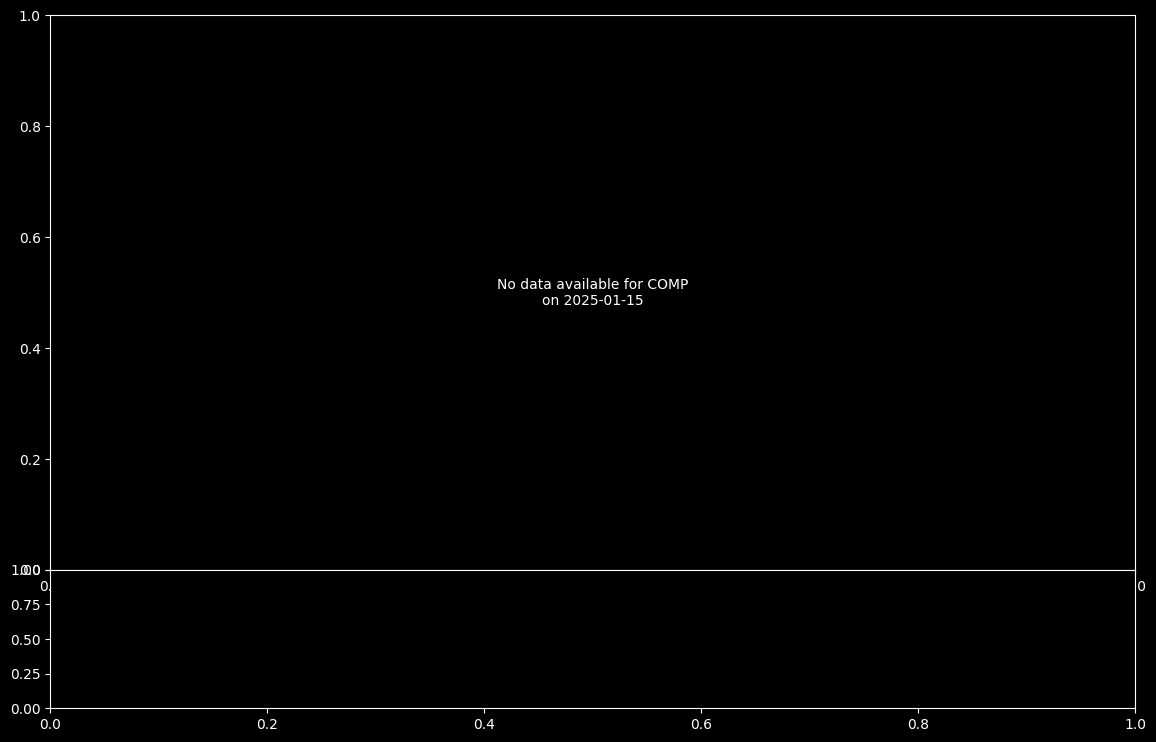

In [48]:
#### plot #1; SINGLE stock, one (1) day, intraday price action. ####
plot_single_stock(quick_dirty_list, screen_date)

plot #2; MULTI-stock intraday price action grid of subplots.

In [49]:
def plot_multiple_stocks_grid(symbols_list, target_date):
    """
    Creates a grid of subplots showing price action for multiple stocks.
    Each stock gets its own price and volume panel with full annotations.
    """
    target_date = pd.to_datetime(target_date)
    prev_day = target_date - pd.DateOffset(days=1)
    
    # Calculate grid dimensions
    n_stocks = len(symbols_list)
    n_cols = min(2, n_stocks)
    n_rows = (n_stocks + n_cols - 1) // n_cols
    
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(14 * n_cols, 9 * n_rows))
    outer_grid = fig.add_gridspec(n_rows, n_cols, hspace=0.25, wspace=0.2)
    
    for idx, symbol in enumerate(symbols_list):
        row = idx // n_cols
        col = idx % n_cols
        inner_grid = outer_grid[row, col].subgridspec(2, 1, height_ratios=[4, 1], hspace=0)
        ax1 = fig.add_subplot(inner_grid[0])
        ax2 = fig.add_subplot(inner_grid[1])
        
        # Get data
        ticker = yf.Ticker(symbol)
        prev_data = ticker.history(start=prev_day, end=target_date, interval='1d')
        today_data = ticker.history(start=target_date, 
                                  end=target_date + pd.DateOffset(days=1), 
                                  interval='1m')
        
        if today_data.empty:
            ax1.text(0.5, 0.5, f"No data available for {symbol}\non {target_date.date()}", 
                    ha='center', va='center')
            continue
        
        # Timezone handling
        if today_data.index.tz is not None:
            today_data.index = today_data.index.tz_convert('US/Eastern')
        else:
            today_data.index = today_data.index.tz_localize('UTC').tz_convert('US/Eastern')
        
        today_data = today_data.between_time('9:30', '16:00')
        
        # Calculate first 10 minutes for low and first hour for high
        first_10min_data = today_data.between_time('9:30', '9:40')
        first_hour_data = today_data.between_time('9:30', '10:30')
        
        if not first_hour_data.empty and not first_10min_data.empty:
            # Find low in first 10 minutes
            first_10min_low = first_10min_data['Low'].min()
            low_timestamp = first_10min_data[first_10min_data['Low'] == first_10min_low].index[0]
            
            # Find high in first hour
            first_hour_high = first_hour_data['High'].max()
            high_timestamp = first_hour_data[first_hour_data['High'] == first_hour_high].index[0]
            
            first_hour_gain_pct = ((first_hour_high - first_10min_low) / first_10min_low) * 100
        else:
            first_hour_gain_pct = 0.0
        
        # Plot price action
        ax1.plot(today_data.index, today_data['Close'], 
                color='white', linewidth=1.5, label='Price')
        
        # Calculate levels
        today_open = today_data['Open'].iloc[0]
        today_high = today_data['High'].max()
        today_low = today_data['Low'].min()
        today_close = today_data['Close'].iloc[-1]
        
        # Calculate and set y-axis limits
        if not prev_data.empty:
            prev_day_high = prev_data['High'].iloc[-1]
            prev_day_low = prev_data['Low'].iloc[-1]
            prev_day_close = prev_data['Close'].iloc[-1]
            
            all_price_levels = [
                prev_day_high, prev_day_low, prev_day_close,
                today_high, today_low, today_open, today_close
            ]
            
            min_price = min(all_price_levels)
            max_price = max(all_price_levels)
            price_range = max_price - min_price
            padding = price_range * 0.1
            
            ax1.set_ylim(min_price - padding, max_price + padding)
            
            # Draw price levels with reduced alpha
            ax1.axhline(y=prev_day_high, color='red', linestyle='--', alpha=0.3)
            ax1.axhline(y=prev_day_low, color='green', linestyle='--', alpha=0.3)
            ax1.axhline(y=prev_day_close, color='yellow', linestyle='--', alpha=0.3)
            
            # Add labels with smaller font
            label_offset = price_range * 0.02
            ax1.text(today_data.index[-1], prev_day_high + label_offset, 
                    f' PDH: ${prev_day_high:.2f}', color='red', alpha=0.8, 
                    va='bottom', ha='left', fontsize=7)
            ax1.text(today_data.index[-1], prev_day_low - label_offset, 
                    f' PDL: ${prev_day_low:.2f}', color='green', alpha=0.8, 
                    va='top', ha='left', fontsize=7)
            ax1.text(today_data.index[-1], prev_day_close, 
                    f' PDC: ${prev_day_close:.2f}', color='yellow', alpha=0.8, 
                    va='center', ha='left', fontsize=7)
            
            # Add arrows and timestamps for first hour range
            if not first_hour_data.empty and not first_10min_data.empty:
                # Add arrow and timestamp for 10min low (red)
                ax1.annotate(f'${first_10min_low:.2f}\n{low_timestamp.strftime("%H:%M")}', 
                            xy=(low_timestamp, first_10min_low),
                            xytext=(low_timestamp, first_10min_low - (price_range * 0.03)),
                            color='red', alpha=0.9, fontsize=7,
                            ha='center', va='top',
                            arrowprops=dict(arrowstyle='->', color='red', alpha=0.8, linewidth=2))
                
                # Add arrow and timestamp for hour high (green)
                ax1.annotate(f'${first_hour_high:.2f}\n{high_timestamp.strftime("%H:%M")}',
                            xy=(high_timestamp, first_hour_high),
                            xytext=(high_timestamp, first_hour_high + (price_range * 0.03)),
                            color='green', alpha=0.9, fontsize=7,
                            ha='center', va='bottom',
                            arrowprops=dict(arrowstyle='simple', color='green', alpha=0.8, linewidth=2))
        
        # Plot volume
        colors = ['red' if close < open else '#00ff00' 
                 for close, open in zip(today_data['Close'], today_data['Open'])]
        ax2.bar(today_data.index, today_data['Volume'], 
                color=colors, alpha=0.7, width=0.5/(len(today_data.index)))
        
        # Format axes
        for ax in [ax1, ax2]:
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=pytz.timezone('US/Eastern')))
            ax.xaxis.set_major_locator(mdates.HourLocator(interval=1, tz=pytz.timezone('US/Eastern')))
            ax.grid(True, alpha=0.15)
            ax.set_xlim(today_data.index[0] - pd.Timedelta(minutes=5),
                       today_data.index[-1] + pd.Timedelta(minutes=5))
        
        ax1.set_xticklabels([])
        
        # Add title and labels
        if not prev_data.empty:
            gap_pct = (today_open - prev_day_close) / prev_day_close * 100
            title = f'${symbol} G:{gap_pct:+.1f}% | 10m→1h:{first_hour_gain_pct:+.1f}%'
        else:
            title = f'${symbol}'
        
        ax1.set_title(title, fontsize=9, pad=8)
        ax1.set_ylabel('Price ($)', fontsize=8)
        ax2.set_ylabel('Volume', fontsize=8)
        
        # Add last price
        ax1.text(today_data.index[-1], today_close, f'Last: ${today_close:.2f}', 
            color='white', fontsize=7, va='center', ha='left')
    
    plt.show()

In [50]:
#### plot #2; MULTI-stock intraday price action grid of subplots. ####
plot_multiple_stocks_grid(quick_dirty_list, screen_date)

$COMP: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$BECN: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$TIGO: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$RKT: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$VLY: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$OPFI: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$TPH: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$POWL: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$DFH: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$SFBS: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$RSI: possibly delisted; no price data found  (1m 2025

plot #3; overlay stock prices %.

In [51]:
def plot_multiple_daily_price_levels(symbols_list, target_date):
    target_date = pd.to_datetime(target_date)
    prev_day = target_date - pd.DateOffset(days=1)
    
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(14, 9))
    gs = fig.add_gridspec(2, 1, height_ratios=[4, 1], hspace=0)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    
    # Generate distinct colors for each stock
    colors = plt.cm.rainbow(np.linspace(0, 1, len(symbols_list)))
    
    # Store min/max percentage changes for y-axis scaling
    all_changes = []
    
    for symbol, color in zip(symbols_list, colors):
        ticker = yf.Ticker(symbol)
        
        # Get data
        today_data = ticker.history(start=target_date, 
                                  end=target_date + pd.DateOffset(days=1), 
                                  interval='1m')
        
        if today_data.empty:
            print(f"No data available for {symbol} on {target_date.date()}")
            continue
            
        # Timezone handling
        if today_data.index.tz is not None:
            today_data.index = today_data.index.tz_convert('US/Eastern')
        else:
            today_data.index = today_data.index.tz_localize('UTC').tz_convert('US/Eastern')
        
        # Filter market hours
        today_data = today_data.between_time('9:30', '16:00')
        
        if len(today_data) == 0:
            continue
            
        # Calculate percentage change from open
        open_price = today_data['Open'].iloc[0]
        today_data['pct_change'] = ((today_data['Close'] - open_price) / open_price) * 100
        
        # Plot price action as percentage change
        line = ax1.plot(today_data.index, today_data['pct_change'],
                       color=color, linewidth=1.5, label=f'${symbol}')
        
        # Store data for y-axis scaling
        all_changes.extend(today_data['pct_change'].tolist())
        
        # Plot volume
        ax2.bar(today_data.index, today_data['Volume'],
                color=color, alpha=0.3, width=0.7/(len(today_data.index)))
    
    # Set y-axis limits with padding
    if all_changes:
        change_range = max(all_changes) - min(all_changes)
        padding = change_range * 0.1
        ax1.set_ylim(min(all_changes) - padding, max(all_changes) + padding)
    
    # Format axes
    for ax in [ax1, ax2]:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=pytz.timezone('US/Eastern')))
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=1, tz=pytz.timezone('US/Eastern')))
        ax.grid(True, alpha=0.15)
    
    # Remove x-axis labels from top subplot
    ax1.set_xticklabels([])
    
    # Customize appearance
    fig.suptitle(f'Multiple Stock Comparison - {target_date.strftime("%Y-%m-%d")}',
                 y=0.95, fontsize=12)
    ax1.set_ylabel('% Change from Open', fontsize=10)
    ax2.set_ylabel('Volume', fontsize=10)
    
    # Add legend
    ax1.legend(loc='upper left', bbox_to_anchor=(0, 1),
              ncol=len(symbols_list)//2 + 1)
    
    plt.show()

$COMP: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$BECN: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$TIGO: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)


No data available for COMP on 2025-01-15
No data available for BECN on 2025-01-15
No data available for TIGO on 2025-01-15


$RKT: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$VLY: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$OPFI: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)


No data available for RKT on 2025-01-15
No data available for VLY on 2025-01-15
No data available for OPFI on 2025-01-15


$TPH: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$POWL: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)


No data available for TPH on 2025-01-15
No data available for POWL on 2025-01-15


$DFH: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$SFBS: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$RSI: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)


No data available for DFH on 2025-01-15
No data available for SFBS on 2025-01-15
No data available for RSI on 2025-01-15


$MTH: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$HMY: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)


No data available for MTH on 2025-01-15
No data available for HMY on 2025-01-15


$GRBK: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$SNV: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$PAGP: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)


No data available for GRBK on 2025-01-15
No data available for SNV on 2025-01-15
No data available for PAGP on 2025-01-15


$AZEK: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$SG: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$EBC: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)


No data available for AZEK on 2025-01-15
No data available for SG on 2025-01-15
No data available for EBC on 2025-01-15


$COLB: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$OZK: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$KTOS: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)


No data available for COLB on 2025-01-15
No data available for OZK on 2025-01-15
No data available for KTOS on 2025-01-15


$ZION: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$WAL: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$FNB: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)


No data available for ZION on 2025-01-15
No data available for WAL on 2025-01-15
No data available for FNB on 2025-01-15


$AUB: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$TREX: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$IAC: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)


No data available for AUB on 2025-01-15
No data available for TREX on 2025-01-15
No data available for IAC on 2025-01-15


$FULT: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$GENI: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$ERJ: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)


No data available for FULT on 2025-01-15
No data available for GENI on 2025-01-15
No data available for ERJ on 2025-01-15


$UWMC: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$CDE: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$PB: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)


No data available for UWMC on 2025-01-15
No data available for CDE on 2025-01-15
No data available for PB on 2025-01-15


$BBAR: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$NEXT: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$WSC: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)


No data available for BBAR on 2025-01-15
No data available for NEXT on 2025-01-15
No data available for WSC on 2025-01-15


$HL: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$VNO: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$GTLB: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)


No data available for HL on 2025-01-15
No data available for VNO on 2025-01-15
No data available for GTLB on 2025-01-15


$FRSH: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$ONB: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)


No data available for FRSH on 2025-01-15
No data available for ONB on 2025-01-15


$BANC: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$FRME: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$VERX: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)


No data available for BANC on 2025-01-15
No data available for FRME on 2025-01-15
No data available for VERX on 2025-01-15


$BRZE: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$CZR: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)


No data available for BRZE on 2025-01-15
No data available for CZR on 2025-01-15


$CBU: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$FIBK: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$FHB: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)


No data available for CBU on 2025-01-15
No data available for FIBK on 2025-01-15
No data available for FHB on 2025-01-15


$TGTX: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$SITE: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$FFBC: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)


No data available for TGTX on 2025-01-15
No data available for SITE on 2025-01-15
No data available for FFBC on 2025-01-15


$PATH: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$CAKE: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$VAC: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)


No data available for PATH on 2025-01-15
No data available for CAKE on 2025-01-15
No data available for VAC on 2025-01-15


$CXT: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$NNN: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$ORI: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$RGEN: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)


No data available for CXT on 2025-01-15
No data available for NNN on 2025-01-15
No data available for ORI on 2025-01-15
No data available for RGEN on 2025-01-15


$TRIP: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$SKY: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$TEX: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)


No data available for TRIP on 2025-01-15
No data available for SKY on 2025-01-15
No data available for TEX on 2025-01-15


$ADT: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$ZWS: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$MGM: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)


No data available for ADT on 2025-01-15
No data available for ZWS on 2025-01-15
No data available for MGM on 2025-01-15


$BLD: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$PFS: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$UCB: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)


No data available for BLD on 2025-01-15
No data available for PFS on 2025-01-15
No data available for UCB on 2025-01-15


$CVLT: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$PAAS: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)


No data available for CVLT on 2025-01-15
No data available for PAAS on 2025-01-15


$BXMT: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$MTG: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$ONTO: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)


No data available for BXMT on 2025-01-15
No data available for MTG on 2025-01-15
No data available for ONTO on 2025-01-15


$HASI: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$LTH: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$BROS: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$NFG: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)


No data available for HASI on 2025-01-15
No data available for LTH on 2025-01-15
No data available for BROS on 2025-01-15


$USM: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$LPX: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)


No data available for NFG on 2025-01-15
No data available for USM on 2025-01-15
No data available for LPX on 2025-01-15


$CIVI: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$BKU: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$AYI: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)


No data available for CIVI on 2025-01-15
No data available for BKU on 2025-01-15
No data available for AYI on 2025-01-15


$GBCI: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
$COOP: possibly delisted; no price data found  (1m 2025-01-15 00:00:00 -> 2025-01-16 00:00:00)
/var/folders/8w/4mj_4m4d0rs1q22bl9g77hhw0000gn/T/ipykernel_66336/104178327.py:78: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc='upper left', bbox_to_anchor=(0, 1),


No data available for GBCI on 2025-01-15
No data available for COOP on 2025-01-15


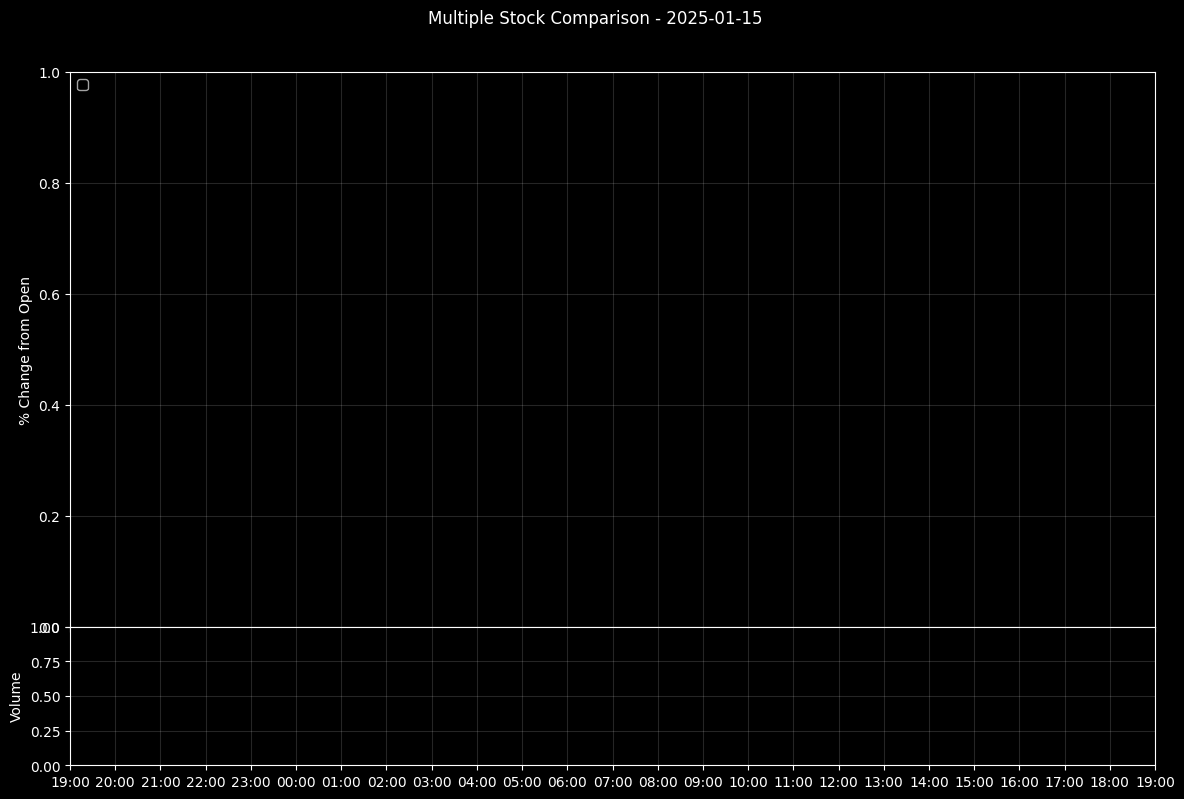

In [52]:
#### plot #3; overlay stock prices %. ####
plot_multiple_daily_price_levels(quick_dirty_list, screen_date)

| END OF PROGRAM |
|-|
## IDEATION (features)
|idea|description|
|-|-|
|$ (dollar signs) PASS/FAIL|think about scoring with $ (dollar signs), pass/fail sub-score, and total quantitative scoring|
|
|
|
|